## Description

It's DL based model that takes human face sketch as a input and based on that face sketch the model will going to generate a new realistic looking human face.

## Importing libraries

In [1]:
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print('Tensorflow version used:',tf.__version__)

Tensorflow version used: 2.2.0


## Loading the dataset

In [2]:
Dataset_path = 'C:/Users/Naman Gupta/Desktop/human_project/dataset/'

training_path = Dataset_path+'training/'
test_path = Dataset_path+'test/'

Original image shape:  (256, 512, 3)


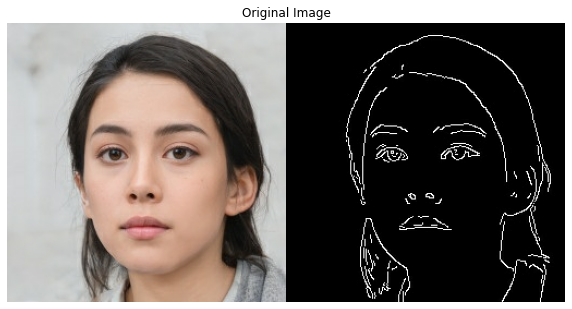

In [3]:
original_img = tf.io.read_file(str(training_path+'glued_human_face_50.jpg'))
original_img = tf.io.decode_jpeg(original_img)

plt.figure(figsize=(10,6))
plt.imshow(original_img)
plt.title('Original Image')
plt.axis('off')
print('Original image shape: ',original_img.shape);

#### Loading the data by splitting the pixels and seperating the images

In [4]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]
    w = w // 2
  
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

Input image shape:  (256, 256, 3)
Real image shape:  (256, 256, 3)


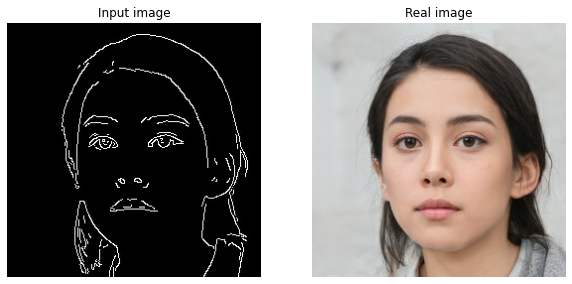

In [5]:
input_img, real_img = load(training_path+'glued_human_face_50.jpg')
plt.figure(figsize=(10,6))


plt.subplot(1, 2, 1)
plt.imshow(input_img/255.0)
plt.title('Input image')
plt.axis('off')
print('Input image shape: ',input_img.shape)

plt.subplot(1, 2, 2)
plt.imshow(real_img/255.0)
plt.title('Real image')
plt.axis('off')
print('Real image shape: ',real_img.shape);

Note: Shape changed from (256, 512, 3) to (256, 256, 3) because we seperated the original image into two different images

## Data Preprocessing

In [6]:
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 8

# Because training set consist of 400 images
BUFFER_SIZE = 400

# # Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

### We need to apply random jittering and mirroring to preprocess the training set.

Functions to preprocess the training set:<br>

1. Resize each 256 x 256 image to a larger height and width 286 x 286.
2. Randomly crop it back to 256 x 256.
3. Randomly flip the image horizontally i.e. left to right (random mirroring).
4. Normalize the images to the [-1, 1] range.

In [7]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    return cropped_image[0], cropped_image[1]

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

In [8]:
@tf.function()
def random_jitter(input_image, real_image):
    
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

							Manipulated images


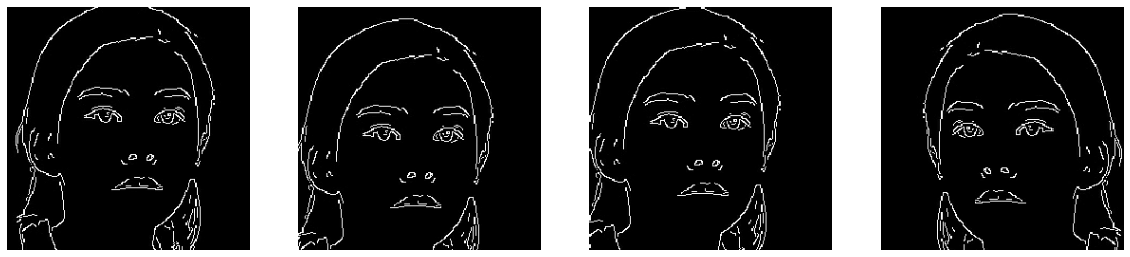

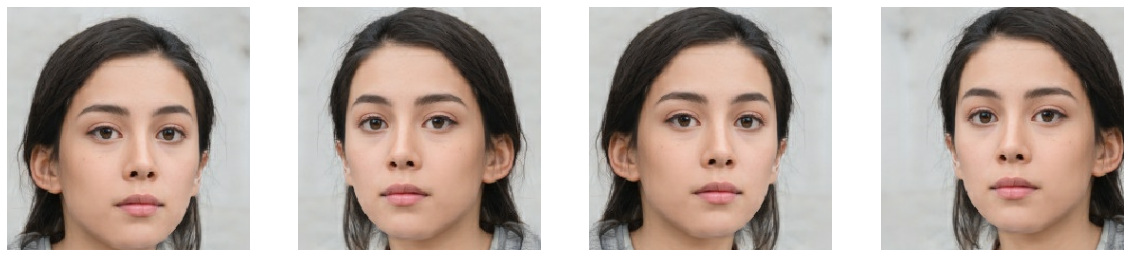

In [9]:
print('\t\t\t\t\t\t\t' + 'Manipulated images')

plt.figure(figsize=(20,20))
for i in range(4):
    rj_inp, rj_re = random_jitter(input_img, real_img)
    plt.subplot(1, 4, i+1)
    plt.imshow(rj_inp/255.0)
    plt.axis('off')
    
plt.figure(figsize=(20,20))
for i in range(4):
    rj_inp, rj_re = random_jitter(input_img, real_img)
    plt.subplot(1, 4, i+1)
    plt.imshow(rj_re/255.0)
    plt.axis('off')

## Model Building

Functions that load and preprocess the training and test sets:

In [10]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

Input pipeline

In [11]:
train_dataset = tf.data.Dataset.list_files(training_path+'*.jpg')
train_dataset = train_dataset.map(load_image_train)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files(test_path+'*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Model Architecture

The generator of our pix2pix cGAN is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). <br>

In [12]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters,size,strides=2,padding='same',kernel_initializer=initializer,use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
        result.add(tf.keras.layers.ReLU())
    return result

In [13]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(input_img, 0))
print('Down Sample results:', down_result.shape)

up_model = upsample(3, 4)
up_result = up_model(down_result)
print('Up Sample results:', up_result.shape)

Down Sample results: (1, 128, 128, 3)
Up Sample results: (1, 256, 256, 3)


### Defining the Generator

In [14]:
def Generator():

    down_stack = [downsample(64, 4, apply_batchnorm=False),
                    downsample(128, 4),
                    downsample(256, 4),
                    downsample(512, 4),
                    downsample(512, 4), 
                    downsample(512, 4),
                    downsample(512, 4), 
                    downsample(512, 4)]

    up_stack = [upsample(512, 4, apply_dropout=True),
                upsample(512, 4, apply_dropout=True),
                upsample(512, 4, apply_dropout=True),
                upsample(512, 4),
                upsample(256, 4),
                upsample(128, 4),
                upsample(64, 4)]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')
    
    inputs = tf.keras.layers.Input(shape=[256,256,3])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

#### Visualize the generator model architecture:

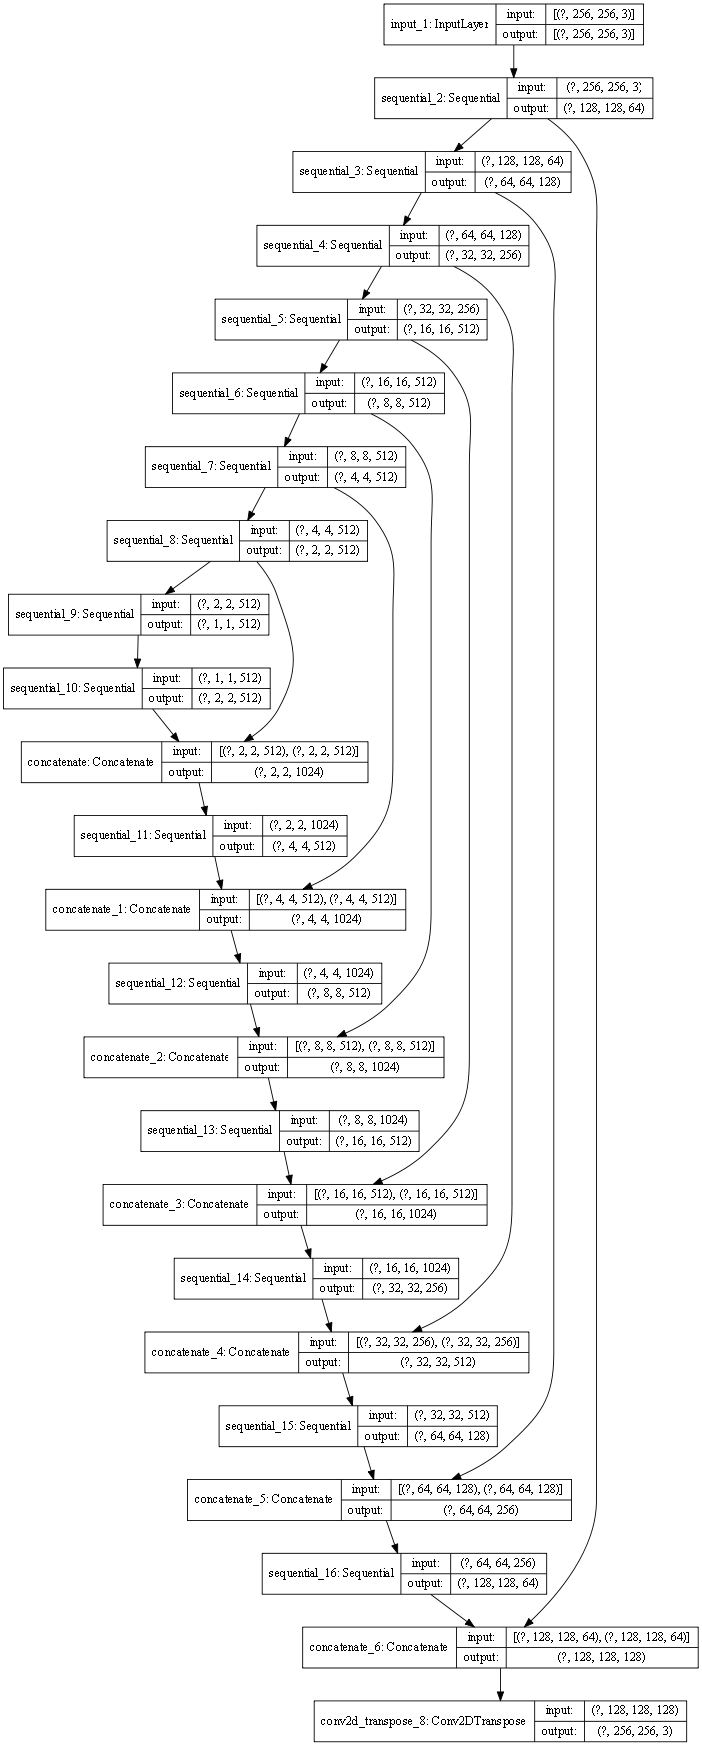

In [15]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


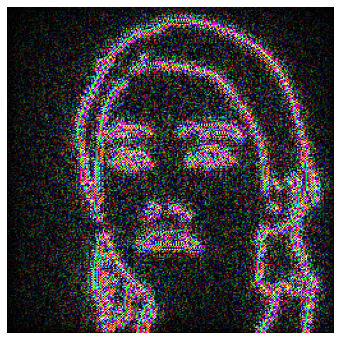

In [16]:
gen_output = generator(input_img[tf.newaxis,...], training=False)

plt.figure(figsize=(6,6))
plt.imshow(gen_output[0,...])
plt.axis('off');

#### Defining the generator loss

In [17]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (100 * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

Note: GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image

### Defining the discriminator

In [18]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1) 
    down3 = downsample(256, 4)(down2)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) 

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) 

    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

#### Visualize the discriminator model architecture:

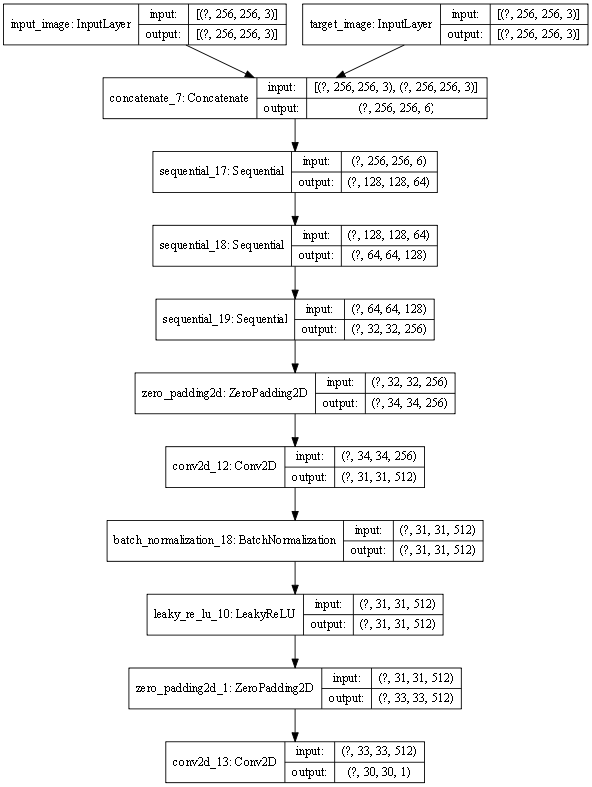

In [19]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

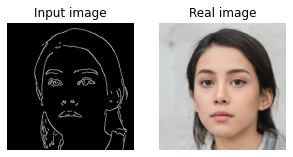

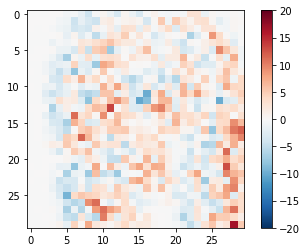

In [20]:
plt.figure(figsize=(5,5))

plt.subplot(1, 2, 1)
plt.imshow(input_img/255.0)
plt.title('Input image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(real_img/255.0)
plt.title('Real image')
plt.axis('off');

plt.figure()
disc_out = discriminator([input_img[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar();

#### Defining the discriminator loss

In [21]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

## Model training

In [22]:
# Model Optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [23]:
# function to plot images during training

def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [24]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [25]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()
        print('Training Started')
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
        print('\nTraining Completed')
    
        for example_input, example_target in test_ds.take(1):
              generate_images(generator, example_input, example_target)

        print ('Time taken for {} epoch = {} seconds\n'.format(epoch + 1, round(time.time()-start),2))

Training Started
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Training Completed


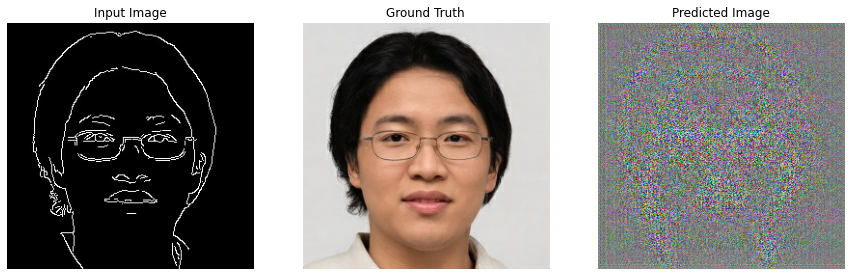

Time taken for 1 epoch = 31 seconds

Training Started
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Training Completed


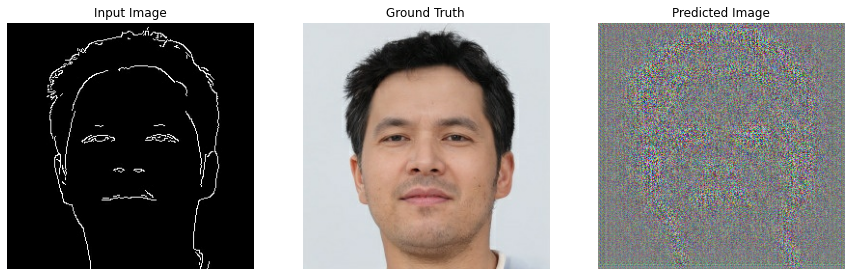

Time taken for 2 epoch = 30 seconds



In [26]:
EPOCHS = 2
fit(train_dataset, EPOCHS, test_dataset)

## Saving the Model

In [27]:
generator.save("human_face_model.h5")

## Thank you